# Model Inference

## Prepare Library, Parameters, and Dependencies

In [1]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
# UNCOMMENT THIS IF YOU USE GOOGLE COLAB

# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# Check TensorFlow Version and GPU Availability
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

2.14.0
Num GPUs Available:  0


In [4]:
# Set Parameters
SEGMENTATION_MODEL_PATH = "models/segmentation_model_1/tflite/model.tflite"
CLASSIFICATION_MODEL_PATH = "models/classification_model_1/tflite/model.tflite"
TEST_PREDICT_DIR = 'datasets/test_predict'

CLASS_NAMES = ['mild', 'normal', 'severe']

## Load TFLite Model and Predict Image Path

In [5]:
# Load TF Lite model
interpreter_segmentation = tf.lite.Interpreter(SEGMENTATION_MODEL_PATH)
interpreter_classification = tf.lite.Interpreter(CLASSIFICATION_MODEL_PATH)

In [6]:
# Load Predict Image Path
image_path = []
for root, dirs, files in os.walk(TEST_PREDICT_DIR):
    for file in files:
        path_og = os.path.join(root,file)
        image_path.append(path_og)

## Run Inference

In [7]:
# Allocate Tensors for Input and Output of Model
interpreter_segmentation.allocate_tensors()
interpreter_classification.allocate_tensors()

In [8]:
# Get Height and Width of Input Image
_, height, width, _ = interpreter_segmentation.get_input_details()[0]['shape']

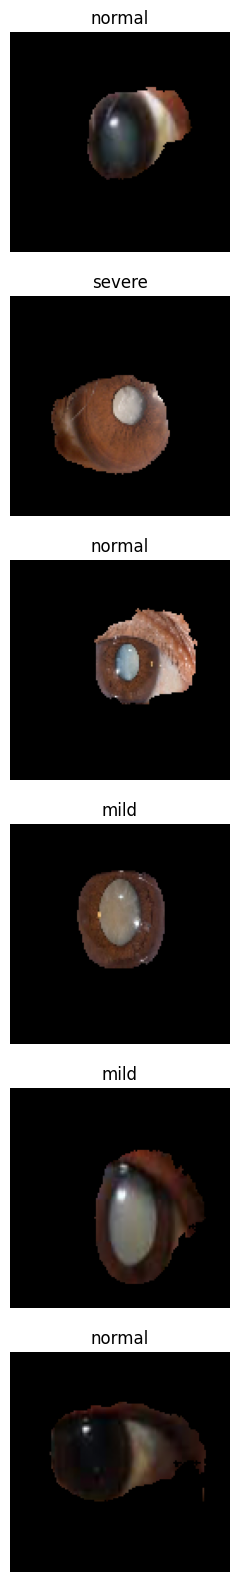

In [19]:
plt.figure(figsize=(20,20))
k = 0

# Run Inference for Each Image
for path in image_path:
    # Load Image from Path and Resize
    image = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    image = cv2.resize(image, (width, height)).astype(np.float32)
    image = image / 255.0
    
    # Add Batch Dimension
    input_image = np.expand_dims(image, axis=0)
    input_image = np.expand_dims(input_image, axis=-1)
    
    # Set Input and Invoke Segmentation Model
    interpreter_segmentation.set_tensor(interpreter_segmentation.get_input_details()[0]['index'], input_image)
    interpreter_segmentation.invoke()
    
    # Get Output
    output_segmentation = np.squeeze(interpreter_segmentation.get_tensor(interpreter_segmentation.get_output_details()[0]['index']))
    output_segmentation = np.where(output_segmentation > 0.9, 1, 0).astype(np.uint8)
    
    # Multiply Image with Mask
    multipy_image = cv2.imread(path)
    multipy_image = cv2.resize(multipy_image, (width, height))
    multipy_image = cv2.bitwise_and(multipy_image, multipy_image, mask=output_segmentation)
    multipy_image = cv2.cvtColor(multipy_image, cv2.COLOR_BGR2RGB)
    
    # Add Batch Dimension for Predicted Image
    input_image = np.expand_dims(multipy_image, axis=0).astype(np.float32)

    # Set Input and Invoke Classification Model
    interpreter_classification.set_tensor(interpreter_classification.get_input_details()[0]['index'], input_image)
    interpreter_classification.invoke()

    # Get Output
    output_classification = np.squeeze(interpreter_classification.get_tensor(interpreter_classification.get_output_details()[0]['index']))
    output_classification = CLASS_NAMES[np.argmax(output_classification)]
    
    # Plot the Predicted Mask
    plt.subplot(len(image_path),3,1+k*3)
    plt.imshow(multipy_image)
    plt.axis('off')
    plt.title(output_classification)
    k += 1